# Analysis of Disparities in Robustness Across Genders

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from model_info import model_to_params, model_to_traindata, model_to_year, model_to_abrv
from copy import deepcopy

## Data Loading and Annotation

First we will read the CSV using Pandas and add to it some meta data related to the models

In [2]:
en_models = [
    'wav2vec2-large-960h-lv60-self',
    'hubert-large-ls960-ft',
    'wav2vec2-large-robust-ft-libri-960h',
    'wav2vec2-base-960h',
    'whisper-large-v2',
    'whisper-tiny.en',
    'deepspeech',
]
en_models_abrv = [model_to_abrv[m] for m in en_models]

In [3]:
#IMPORTANT: Change the file path to the location of the full_result_df.csv file
full_df = pd.read_csv('results/full_result_df-precomputed_data.csv')
print(len(full_df))
spk_df_en = pd.read_csv('LibriSpeech/SPEAKERS.TSV', sep='\t')
spk_df_es = pd.read_csv('mls_spanish_opus/SPEAKERS.txt')
spk_df = pd.concat([spk_df_en, spk_df_es])
# spk_df = spk_df[(spk_df['split'] == 'test-clean') | (spk_df['split'] == 'test')]
spk_to_sex_dict = {row.speaker_id: row.sex for row in spk_df.iloc}

4013021


In [4]:
full_df['model'].unique()

array(['whisper-medium', 'whisper-large-v2', 'whisper-small.en',
       'whisper-medium.en', 'wav2vec2-large-xlsr-53-spanish',
       'wav2vec2-large-960h-lv60-self', 'whisper-small',
       'wav2vec2-large-960h', 'whisper-tiny', 'wav2vec2-base-960h',
       'whisper-base.en', 'wav2vec2-base-10k-voxpopuli-ft-es',
       'hubert-large-ls960-ft', 'hubert-xlarge-ls960-ft',
       'whisper-tiny.en', 'wav2vec2-large-robust-ft-libri-960h',
       'deepspeech', 'mms-1b-fl102', 'whisper-base'], dtype=object)

In [5]:
full_df = full_df[~(full_df.isna().any(axis=1))]
full_df['model'] = full_df['model'].str.replace('rnnt', 'emformer-rnnt')
# full_df['# Model Params'] = [model_to_params[model] for model in full_df['model']]
# full_df['Training Data (hrs)'] = [model_to_traindata[model] for model in full_df['model']]
full_df['model (abrv)'] = [model_to_abrv.get(m, m) for m in full_df['model']]

In [6]:
uttids = full_df['id']
# full_df['speaker_id'] = [int(row.id.split('-')[0]) if row.dataset == 'librispeech_asr' else int(row.id.split('_')[0]) for row in full_df.iloc]
full_df['speaker_id'] = full_df['id'].str.split(r'-|_').str[0].astype(int)
full_df['speaker_gender'] = [spk_to_sex_dict[sid] for sid in full_df['speaker_id'].values]

In [7]:
full_df['num_ref_chars'] = [len(ref) for ref in full_df['reference']]
full_df['num_ref_words'] = [len(ref.split()) for ref in full_df['reference']]
full_df['num_char_errors'] = full_df['cer'] * full_df['num_ref_chars']
full_df['num_word_errors'] = full_df['wer'] * full_df['num_ref_words']

Separate out the results on clean data

In [8]:
clean_full_df = full_df[full_df['augmentation'] == 'None']
full_df = full_df[(full_df['augmentation'] != 'unoise')]
row = full_df.iloc[0]
clean_row = clean_full_df[(clean_full_df['model'] == row['model']) & (clean_full_df['id'] == row['id'])]
clean_row

,Unnamed: 0,id,reference,prediction,wer,cer,model,augmentation,severity,dataset,runid,model (abrv),speaker_id,speaker_gender,num_ref_chars,num_ref_words,num_char_errors,num_word_errors
104800,0,6930-75918-0000,concord returned to its place amidst the tents,concord returned to its place amidst the tents,0.0,0.0,whisper-medium,None,0,librispeech_asr,1.0,wsp-md,6930,M,46,8,0.0,0.0


In [9]:
full_df['model'].unique()

array(['whisper-medium', 'whisper-large-v2', 'whisper-small.en',
       'whisper-medium.en', 'wav2vec2-large-xlsr-53-spanish',
       'wav2vec2-large-960h-lv60-self', 'whisper-small',
       'wav2vec2-large-960h', 'whisper-tiny', 'wav2vec2-base-960h',
       'whisper-base.en', 'wav2vec2-base-10k-voxpopuli-ft-es',
       'hubert-large-ls960-ft', 'hubert-xlarge-ls960-ft',
       'whisper-tiny.en', 'wav2vec2-large-robust-ft-libri-960h',
       'deepspeech', 'mms-1b-fl102', 'whisper-base'], dtype=object)

## Data Analysis

### Overall Disparity in Robustness

In [10]:
# pt = pd.pivot_table(full_df[~full_df['augmentation'].isna()], values=['wer', 'cer'], columns='speaker_gender', index='model').sort_values(('cer','M')).style.format(decimal='.', thousands='.', precision=2)
overall_results_rows = []
for model in full_df['model'].unique():
    for gender in full_df['speaker_gender'].unique():
        for dataset in full_df['dataset'].unique():
            model_df = full_df[(full_df['model'] == model) & (full_df['speaker_gender'] == gender) & (full_df['dataset'] == dataset)]
            overall_results_rows.append({
                'model': model,
                'speaker_gender': gender,
                'dataset': dataset,
                'wer': model_df['num_word_errors'].sum(skipna=True) / model_df['num_ref_words'].sum(skipna=True),
                'cer': model_df['num_char_errors'].sum(skipna=True) / model_df['num_ref_chars'].sum(skipna=True),
            })
overall_results_df = pd.DataFrame(overall_results_rows)

/tmp/ipykernel_4982/2904677891.py:11: RuntimeWarning: invalid value encountered in scalar divide
  'wer': model_df['num_word_errors'].sum(skipna=True) / model_df['num_ref_words'].sum(skipna=True),
/tmp/ipykernel_4982/2904677891.py:12: RuntimeWarning: invalid value encountered in scalar divide
  'cer': model_df['num_char_errors'].sum(skipna=True) / model_df['num_ref_chars'].sum(skipna=True),


In [12]:
overall_results_df = overall_results_df[~overall_results_df['cer'].isna()]

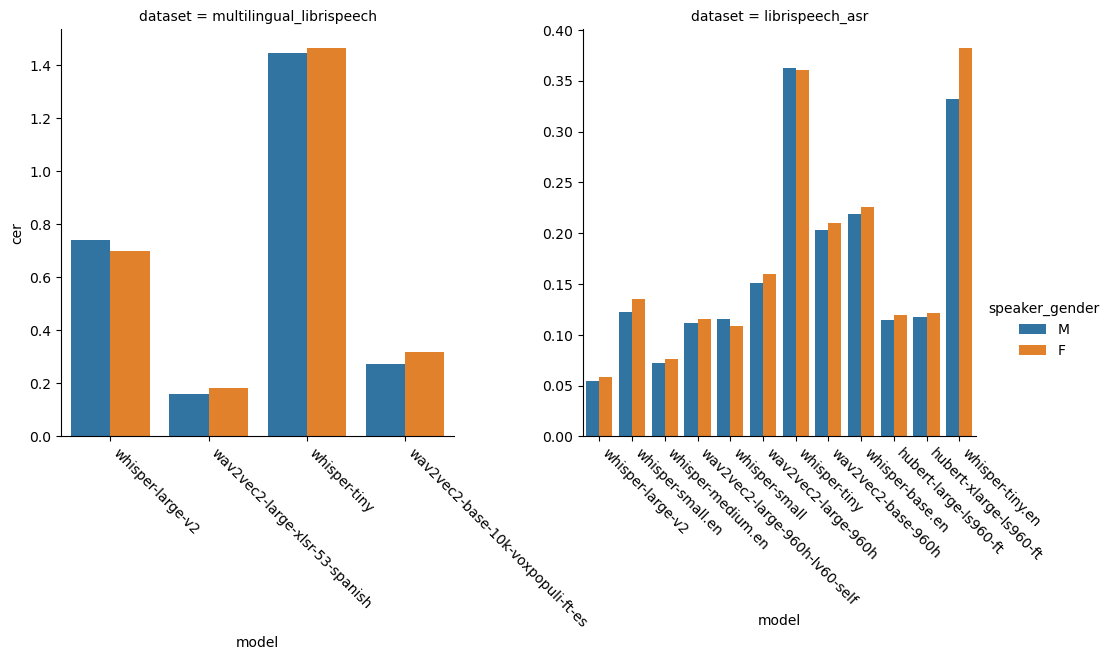

In [13]:
ax = sns.catplot(data=overall_results_df, x='model', y='cer', hue='speaker_gender', col='dataset', kind='bar', sharey=False, sharex=False)
for ax in ax.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

### Measuring Gender Disparity in Robustness

In [10]:
# Compute total words/chars in the reference transcripts, and the number of word/char errors for each dataset, model, augmentation, severity, and gender.
agg_results_df = full_df.pivot_table(index=['dataset', 'model (abrv)', 'augmentation', 'severity', 'speaker_gender'], values=['num_word_errors','num_ref_words','num_char_errors','num_ref_chars'], aggfunc=np.sum).reset_index()
# Compute WER and CER based on the total number of word/char errors and the total number of words/chars in the reference transcripts.
agg_results_df['wer'] = 100 * agg_results_df['num_word_errors'] / agg_results_df['num_ref_words']
agg_results_df['cer'] = 100 * agg_results_df['num_char_errors'] / agg_results_df['num_ref_chars']
agg_results_df = agg_results_df.sort_values(by=['dataset', 'model (abrv)', 'augmentation', 'severity', 'speaker_gender'])

In [11]:
agg_results_df

,dataset,model (abrv),augmentation,severity,speaker_gender,num_char_errors,num_ref_chars,num_ref_words,num_word_errors,wer,cer
0,librispeech_asr,ds,None,0,F,7324.000000,142348,26912,4467.0,16.598543,5.145137
1,librispeech_asr,ds,None,0,M,5512.000000,138638,25664,3446.0,13.427369,3.975822
2,librispeech_asr,ds,echo,1,F,47816.000000,142348,26912,19023.0,70.685939,33.590918
3,librispeech_asr,ds,echo,1,M,45817.000000,138638,25664,18028.0,70.246259,33.047938
4,librispeech_asr,ds,echo,2,F,54935.000000,142348,26912,20572.0,76.441736,38.592042
...,...,...,...,...,...,...,...,...,...,...,...
2761,multilingual_librispeech,wsp-tn,tempo_up,2,M,27432.335849,253539,47444,13617.0,28.701206,10.819770
2762,multilingual_librispeech,wsp-tn,tempo_up,3,F,43057.992789,221449,41055,17623.0,42.925344,19.443751
2763,multilingual_librispeech,wsp-tn,tempo_up,3,M,40981.461934,253539,47444,17889.0,37.705505,16.163770
2764,multilingual_librispeech,wsp-tn,tempo_up,4,F,68412.298556,221449,41055,23931.0,58.290099,30.893027


#### Computing Log WER Ratio

$WERR^M_\text{pert,sev} = \log WER^M_\text{pert,sev,female} - \log WER^M_\text{pert,sev,male}$

+ve values indicate that the WER is higher for females than males, and vice versa.

In [12]:
# Compute the average WER and CER for each dataset, model, augmentation and severity.
# This is done only to obtain a DataFrame of the appropriate shape for the next step.
agg_results_diff_df = deepcopy(agg_results_df.pivot_table(index=['dataset', 'model (abrv)', 'augmentation', 'severity'], values=['wer','cer'])).reset_index()
# Compute log WER/CER ratio, and add the WER/CER for males and females to the dataframe
agg_results_diff_df['Log WER Ratio'] = np.log2(agg_results_df[agg_results_df['speaker_gender'] == 'F']['wer'].values / agg_results_df[agg_results_df['speaker_gender'] == 'M']['wer'].values)
agg_results_diff_df['Log CER ratio'] = np.log2(agg_results_df[agg_results_df['speaker_gender'] == 'F']['cer'].values / agg_results_df[agg_results_df['speaker_gender'] == 'M']['cer'].values)
agg_results_diff_df['WER (Males)'] = agg_results_df[agg_results_df['speaker_gender'] == 'M']['wer'].values
agg_results_diff_df['WER (Females)'] = agg_results_df[agg_results_df['speaker_gender'] == 'F']['wer'].values
agg_results_diff_df['CER (Males)'] = agg_results_df[agg_results_df['speaker_gender'] == 'M']['cer'].values
agg_results_diff_df['CER (Females)'] = agg_results_df[agg_results_df['speaker_gender'] == 'F']['cer'].values

#### Overall Log WER Ratio for English

In [13]:
model_results_df = agg_results_df[(agg_results_df['augmentation'].isna() | (agg_results_df['severity'] > 0)) & ~(agg_results_df['augmentation'].str.contains('\+'))]
model_results_df = deepcopy(model_results_df.pivot_table(index=['dataset', 'model (abrv)', 'speaker_gender'], values=['wer','cer'])).reset_index()
model_results_diff_df = deepcopy(model_results_df.pivot_table(index=['dataset', 'model (abrv)'], values=['wer','cer'])).reset_index()
model_results_diff_df['Log WER Ratio'] = np.log2(model_results_df[model_results_df['speaker_gender'] == 'F']['wer'].values / model_results_df[model_results_df['speaker_gender'] == 'M']['wer'].values)
model_results_diff_df['Log CER ratio'] = np.log2(model_results_df[model_results_df['speaker_gender'] == 'F']['cer'].values / model_results_df[model_results_df['speaker_gender'] == 'M']['cer'].values)
model_results_diff_df['WER (Males)'] = model_results_df[model_results_df['speaker_gender'] == 'M']['wer']
model_results_diff_df['WER (Females)'] = model_results_df[model_results_df['speaker_gender'] == 'F']['wer']
model_results_diff_df['CER (Males)'] = model_results_df[model_results_df['speaker_gender'] == 'M']['cer']
model_results_diff_df['CER (Females)'] = model_results_df[model_results_df['speaker_gender'] == 'F']['cer']

/tmp/ipykernel_645/3688417490.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = agg_results_diff_df[(agg_results_diff_df['dataset'] == 'librispeech_asr') & (agg_results_diff_df['model (abrv)'].isin(en_models_abrv)) & (agg_results_df['augmentation'].isna() | (agg_results_df['severity'] > 0)) & (~(agg_results_df['augmentation'].str.contains('+',regex=False)))]


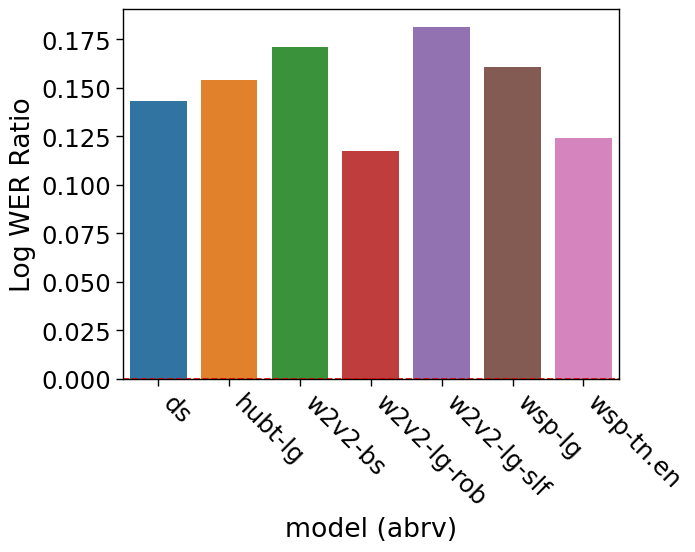

In [14]:
data = agg_results_diff_df[(agg_results_diff_df['dataset'] == 'librispeech_asr') & (agg_results_diff_df['model (abrv)'].isin(en_models_abrv)) & (agg_results_df['augmentation'].isna() | (agg_results_df['severity'] > 0)) & (~(agg_results_df['augmentation'].str.contains('+',regex=False)))]
with sns.plotting_context('paper', font_scale=2.):
    # ax = sns.scatterplot(data=data, x='WER (Males)', y='WER (Females)', hue='model (abrv)', style='model (abrv)')
    # plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    ax = sns.barplot(data=data, x='model (abrv)', y='Log WER Ratio', ci=None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
    ax.axhline(0, ls='--', color='red')

#### Overall Log WER Ratio for Spanish

/tmp/ipykernel_645/850903676.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = agg_results_diff_df[(agg_results_diff_df['dataset'] == 'multilingual_librispeech') & (agg_results_df['augmentation'].isna() | (agg_results_df['severity'] > 0)) & (~(agg_results_df['augmentation'].str.contains('+',regex=False)))]


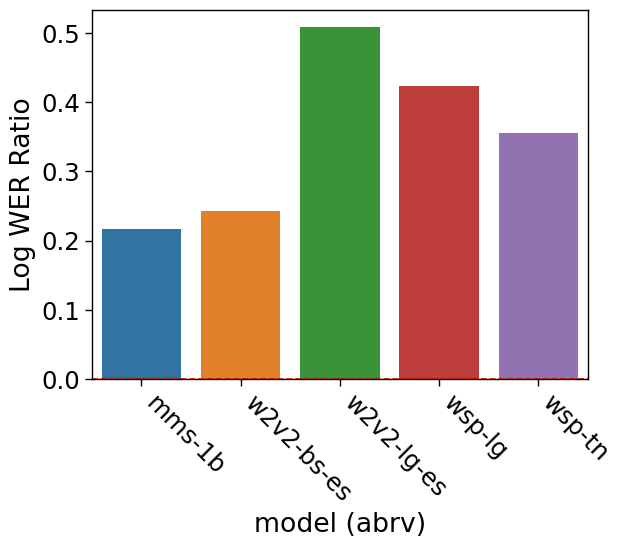

In [28]:
data = agg_results_diff_df[(agg_results_diff_df['dataset'] == 'multilingual_librispeech') & (agg_results_df['augmentation'].isna() | (agg_results_df['severity'] > 0)) & (~(agg_results_df['augmentation'].str.contains('+',regex=False)))]
with sns.plotting_context('paper', font_scale=2.):
    # ax = sns.scatterplot(data=data, x='WER (Males)', y='WER (Females)', hue='model (abrv)', style='model (abrv)')
    # plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    ax = sns.barplot(data=data, x='model (abrv)', y='Log WER Ratio', ci=None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
    ax.axhline(0, ls='--', color='red')

In [15]:
plt.show()

#### Perturbation-wise Log WER Ratio for English

In [16]:
corruption_results_df = agg_results_df.pivot_table(index=['dataset', 'model (abrv)', 'augmentation', 'speaker_gender'], values=['wer', 'cer'], aggfunc=np.mean).reset_index()
corruption_results_diff_df = deepcopy(corruption_results_df.pivot_table(index=['dataset', 'model (abrv)', 'augmentation'], values=['wer','cer'])).reset_index()
corruption_results_diff_df['WER (Males)'] = corruption_results_df[corruption_results_df['speaker_gender'] == 'M']['wer']
corruption_results_diff_df['WER (Females)'] = corruption_results_df[corruption_results_df['speaker_gender'] == 'F']['wer']
corruption_results_diff_df['CER (Males)'] = corruption_results_df[corruption_results_df['speaker_gender'] == 'M']['cer']
corruption_results_diff_df['CER (Females)'] = corruption_results_df[corruption_results_df['speaker_gender'] == 'F']['cer']
corruption_results_diff_df['Log WER Ratio'] = np.log2(corruption_results_df[corruption_results_df['speaker_gender'] == 'F']['wer'].values / corruption_results_df[corruption_results_df['speaker_gender'] == 'M']['wer'].values)
corruption_results_diff_df['Log CER ratio'] = np.log2(corruption_results_df[corruption_results_df['speaker_gender'] == 'F']['cer'].values / corruption_results_df[corruption_results_df['speaker_gender'] == 'M']['cer'].values)

/home/mshah1/anaconda3/envs/audio_robust_bench/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/mshah1/anaconda3/envs/audio_robust_bench/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


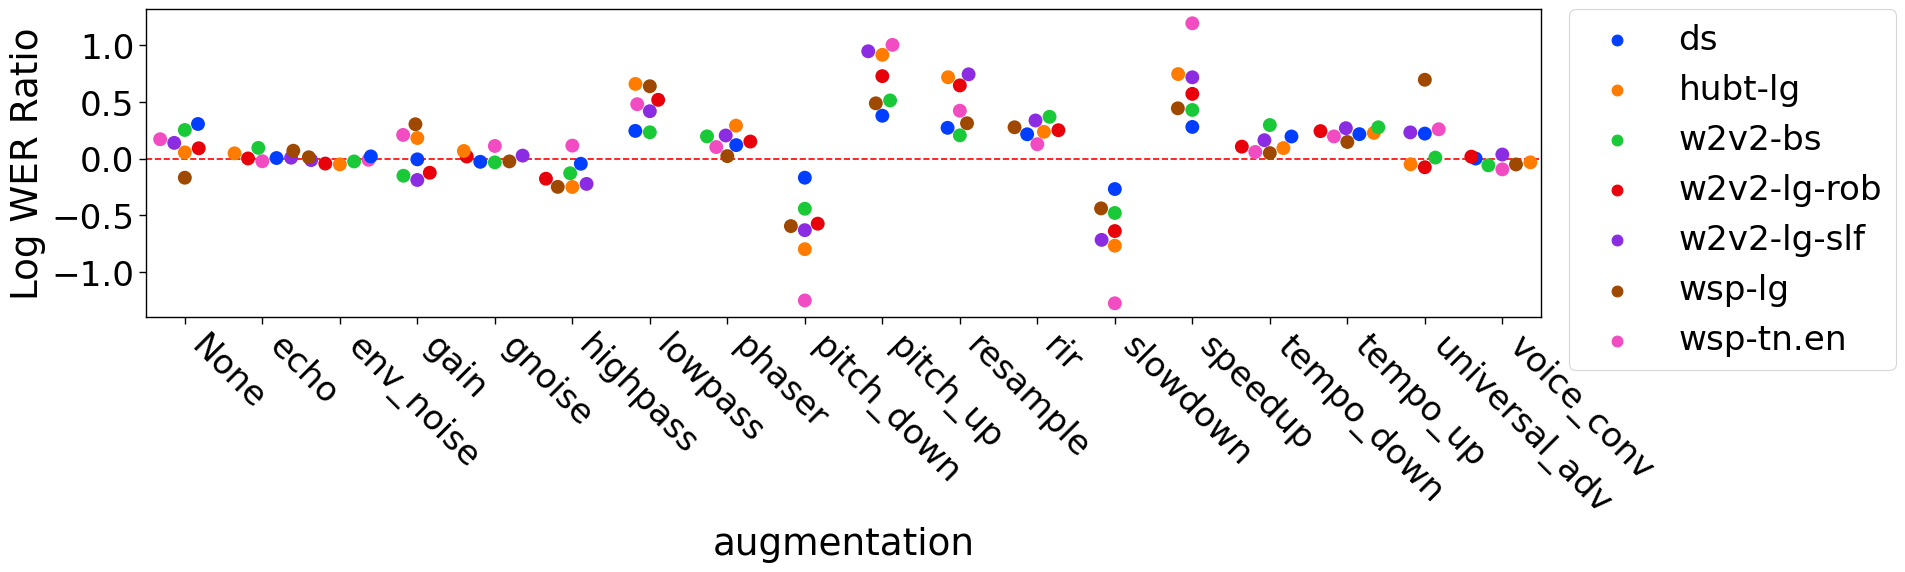

In [25]:
data=corruption_results_diff_df[(corruption_results_diff_df['dataset'] == 'librispeech_asr') & (corruption_results_diff_df['model (abrv)'].isin(en_models_abrv)) & ~(corruption_results_diff_df['augmentation'].str.contains('+',regex=False))]
data = data.pivot_table(index=['model (abrv)', 'augmentation'], values=['Log WER Ratio', 'Log CER ratio']).reset_index()
data['augmentation'] = data['augmentation'].str.replace('voice_conversion_vctk', 'voice_conv')
data['augmentation'] = data['augmentation'].str.replace('env_noise_esc50', 'env_noise')
plt.figure(figsize=(18,4))
with sns.plotting_context('paper', font_scale=2.8):
    # ax = corruption_results_dfg = sns.boxplot(data=data, x='augmentation', y='Log WER Ratio', showfliers=False)
    ax = corruption_results_dfg = sns.swarmplot(data=data, x='augmentation', y='Log WER Ratio', hue='model (abrv)', size=10, palette='bright')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=-45, ha='left')
    ax.axhline(0, ls='--', color='red')
# g.axes[0,0].bar_label(g.axes[0,0].containers[-1], fmt='%.2f', label_type='edge')

#### Perturbation-wise Log WER Ratio for Spanish

/tmp/ipykernel_645/3519758214.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['augmentation'] = data['augmentation'].str.replace('env_noise_esc50', 'env_noise')


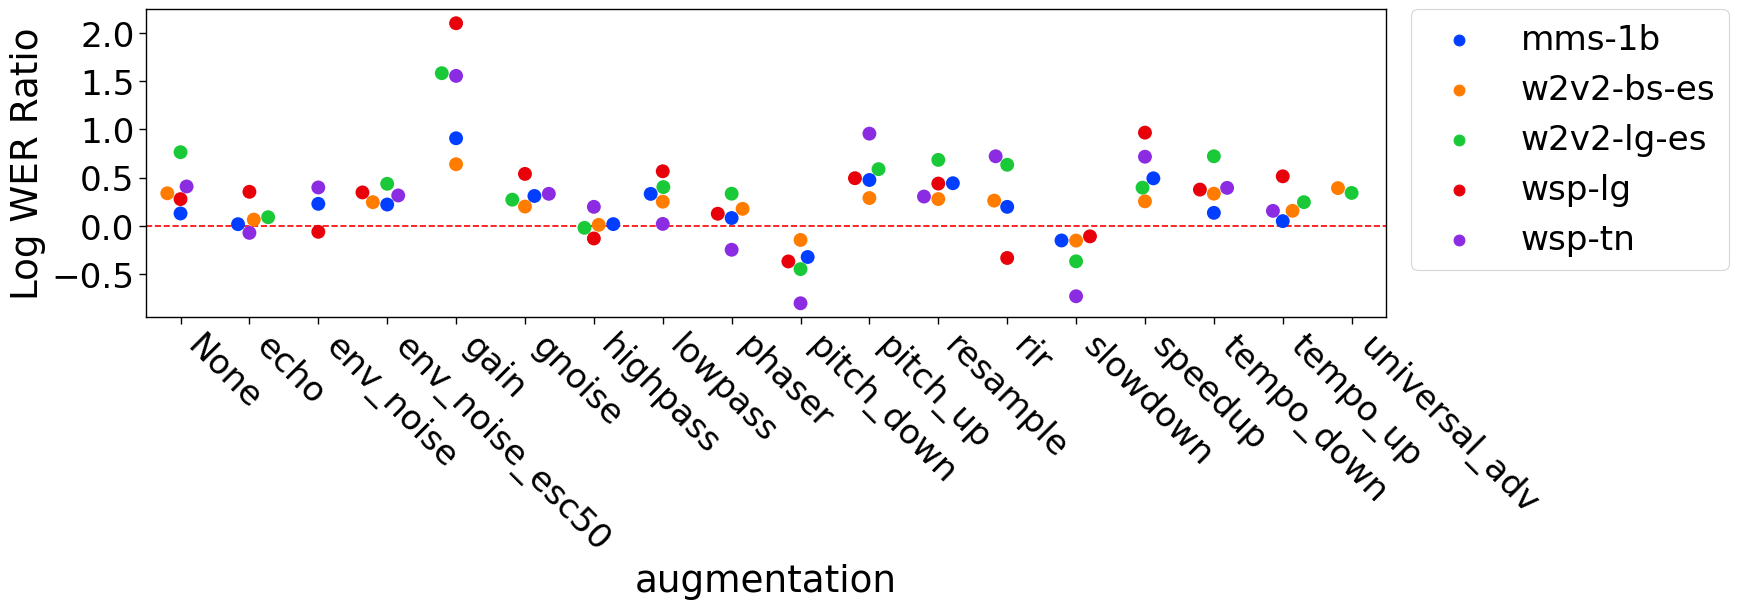

In [26]:
data=corruption_results_diff_df[(corruption_results_diff_df['dataset'] == 'multilingual_librispeech') & ~(corruption_results_diff_df['augmentation'].str.contains('+',regex=False)) & ~(corruption_results_diff_df['augmentation'].isin(['voice_conversion_vctk']))]
plt.figure(figsize=(16,4))
with sns.plotting_context('paper', font_scale=2.8):
    # ax = corruption_results_dfg = sns.boxplot(data=data, x='augmentation', y='Log WER Ratio', showfliers=False)
    ax = corruption_results_dfg = sns.swarmplot(data=data, x='augmentation', y='Log WER Ratio', hue='model (abrv)', size=10, palette='bright')
    data['augmentation'] = data['augmentation'].str.replace('env_noise_esc50', 'env_noise')
    plt.xticks(rotation=-45, ha='left')
    ax.axhline(0, ls='--', color='red')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
# g.axes[0,0].bar_label(g.axes[0,0].containers[-1], fmt='%.2f', label_type='edge')

#### Further Breakdown of results

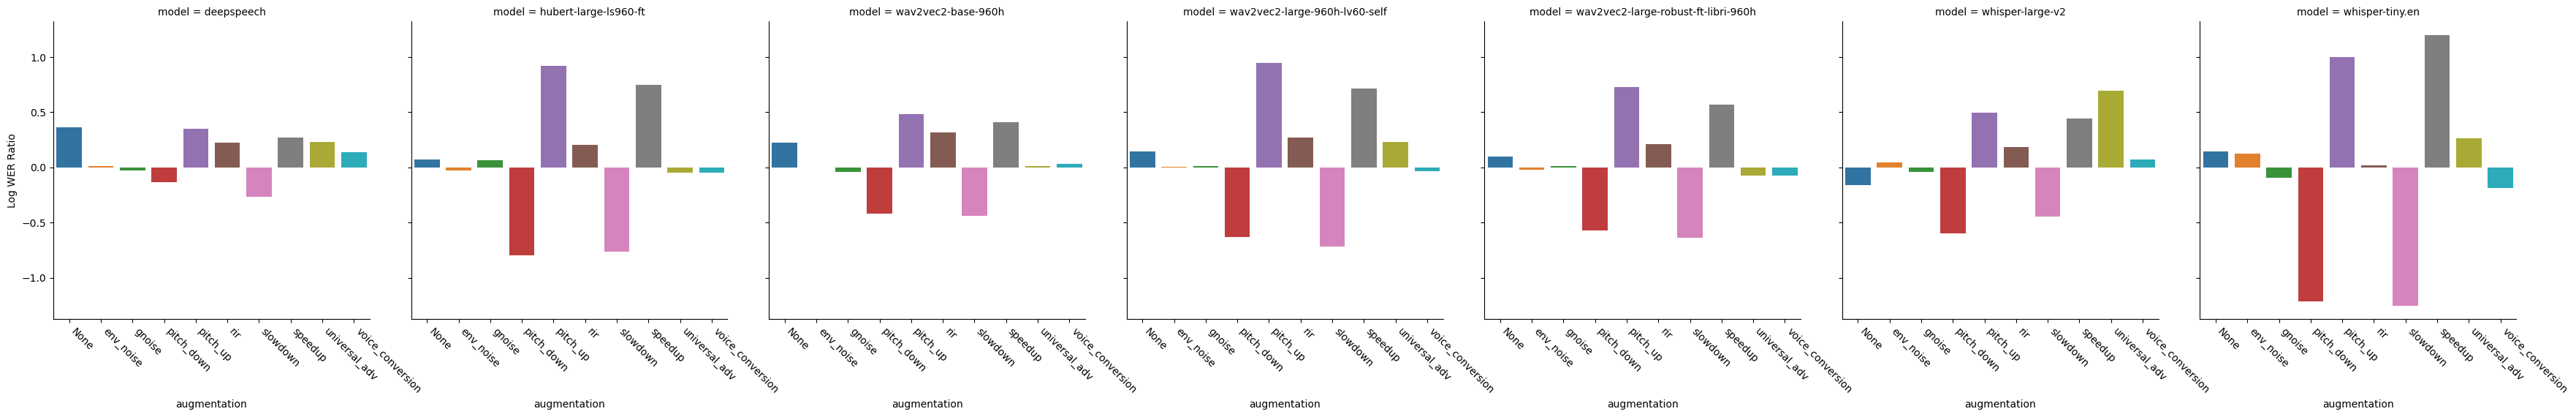

In [85]:
data=corruption_results_diff_df[(corruption_results_diff_df['dataset'] == 'librispeech_asr') & (corruption_results_diff_df['model'].isin(en_models)) & ~(corruption_results_diff_df['augmentation'].str.contains('+',regex=False))]
ax = corruption_results_dfg = sns.catplot(data=data, x='augmentation', y='Log WER Ratio', col='model', kind='bar', ci=False)
ax.set_xticklabels(rotation=-45, ha='left')
# for ax in ax.axes.flatten():
#     ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge')

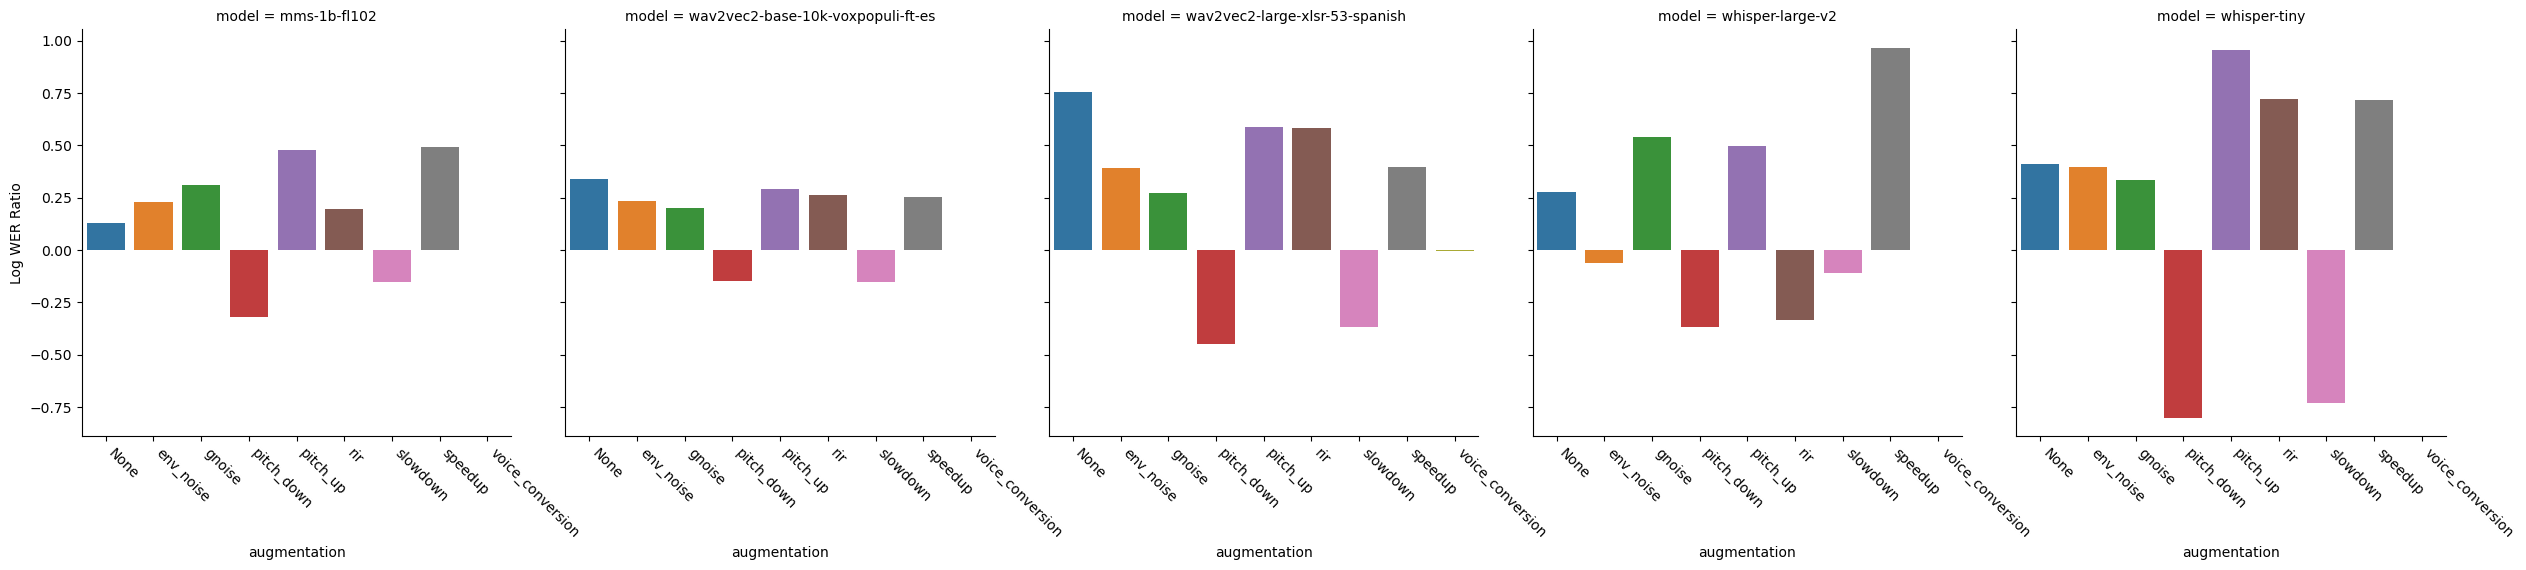

In [87]:
ax = corruption_results_dfg = sns.catplot(data=corruption_results_diff_df[corruption_results_diff_df['dataset'] == 'multilingual_librispeech'], x='augmentation', y='Log WER Ratio', col='model', kind='bar', ci=False)
ax.set_xticklabels(rotation=-45, ha='left')
# for ax in ax.axes.flatten():
#     ax.bar_label(ax.containers[-1], fmt='%.1f', label_type='edge')

In [122]:
severity_results_rows = []
for model in full_df['model'].unique():
    for sev in full_df['severity'].unique():
        print(model, sev)
        for gender in full_df['speaker_gender'].unique():
            for dataset in full_df['dataset'].unique():
                
                model_df = full_df[(full_df['model'] == model)]
                model_df = model_df[(model_df['speaker_gender'] == gender)]
                model_df = model_df[(model_df['severity'] == sev)]
                model_df = model_df[(model_df['dataset'] == dataset)]
                model_df = model_df[~(model_df['augmentation'].str.contains('+', regex=False))]
                if len(model_df) > 0:
                    severity_results_rows.append({
                        'model': model,
                        'speaker_gender': gender,
                        'severity': sev,
                        'dataset': dataset,
                        'wer': model_df['num_word_errors'].sum(skipna=True) / model_df['num_ref_words'].sum(skipna=True),
                        'cer': model_df['num_char_errors'].sum(skipna=True) / model_df['num_ref_chars'].sum(skipna=True),
                    })
severity_results_df = pd.DataFrame(severity_results_rows)
severity_results_df = severity_results_df[~severity_results_df['cer'].isna()]

emformer-rnnt 2
emformer-rnnt 1
emformer-rnnt 3
emformer-rnnt 4
emformer-rnnt 0
whisper-large-v2 2
whisper-large-v2 1
whisper-large-v2 3
whisper-large-v2 4
whisper-large-v2 0
wav2vec2-large-xlsr-53-spanish 2
wav2vec2-large-xlsr-53-spanish 1
wav2vec2-large-xlsr-53-spanish 3
wav2vec2-large-xlsr-53-spanish 4
wav2vec2-large-xlsr-53-spanish 0
wav2vec2-large-960h-lv60-self 2
wav2vec2-large-960h-lv60-self 1
wav2vec2-large-960h-lv60-self 3
wav2vec2-large-960h-lv60-self 4
wav2vec2-large-960h-lv60-self 0
wav2vec2-large-960h 2
wav2vec2-large-960h 1
wav2vec2-large-960h 3
wav2vec2-large-960h 4
wav2vec2-large-960h 0
whisper-tiny 2
whisper-tiny 1
whisper-tiny 3
whisper-tiny 4
whisper-tiny 0
wav2vec2-base-960h 2
wav2vec2-base-960h 1
wav2vec2-base-960h 3
wav2vec2-base-960h 4
wav2vec2-base-960h 0
wav2vec2-base-10k-voxpopuli-ft-es 2
wav2vec2-base-10k-voxpopuli-ft-es 1
wav2vec2-base-10k-voxpopuli-ft-es 3
wav2vec2-base-10k-voxpopuli-ft-es 4
wav2vec2-base-10k-voxpopuli-ft-es 0
hubert-large-ls960-ft 2
hubert

In [100]:
severity_results_df = full_df[~(full_df['augmentation'].str.contains('+',regex=False)) & ((full_df['severity'] > 0) | (full_df['augmentation'].isna()))]
severity_results_df = severity_results_df.pivot_table(index=['dataset', 'model', 'severity', 'speaker_gender'], values=['num_word_errors','num_ref_words','num_char_errors','num_ref_chars'], aggfunc=np.sum).reset_index()
severity_results_df = severity_results_df.sort_values(by=['dataset', 'model', 'severity'])
severity_results_df['wer'] = 100 * severity_results_df['num_word_errors'] / severity_results_df['num_ref_words']
severity_results_df['cer'] = 100 * severity_results_df['num_char_errors'] / severity_results_df['num_ref_chars']

In [101]:
severity_results_diff_df = deepcopy(severity_results_df.pivot_table(index=['dataset', 'model', 'severity'], values=['wer','cer'])).reset_index()
severity_results_diff_df['Log WER Ratio'] = np.log2(severity_results_df[severity_results_df['speaker_gender'] == 'F']['wer'].values / severity_results_df[severity_results_df['speaker_gender'] == 'M']['wer'].values)
severity_results_diff_df['Log CER ratio'] = np.log2(severity_results_df[severity_results_df['speaker_gender'] == 'F']['cer'].values / severity_results_df[severity_results_df['speaker_gender'] == 'M']['cer'].values)

['deepspeech' 'hubert-large-ls960-ft' 'wav2vec2-base-960h'
 'wav2vec2-large-960h-lv60-self' 'wav2vec2-large-robust-ft-libri-960h'
 'whisper-large-v2' 'whisper-tiny.en']


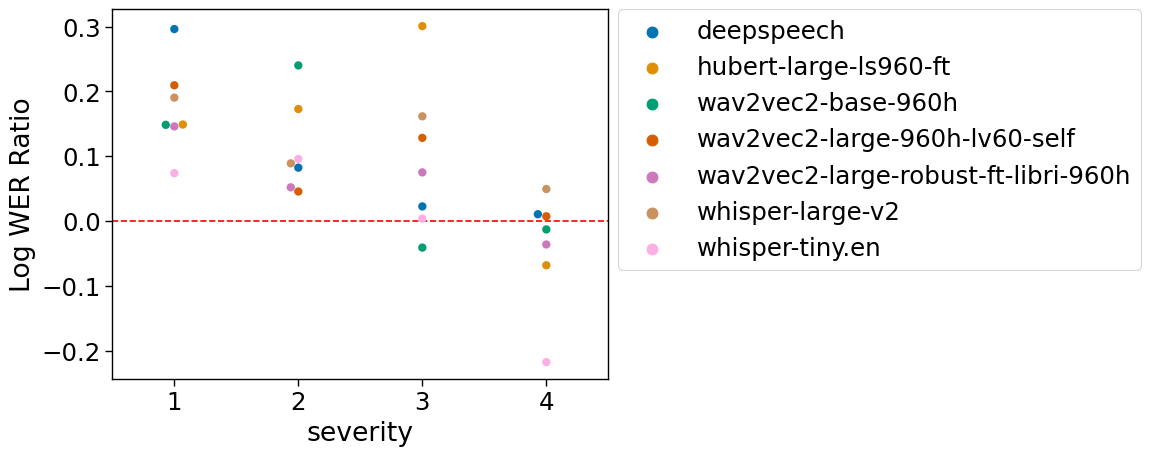

In [180]:
data=severity_results_diff_df[(severity_results_diff_df['dataset'] == 'librispeech_asr') & (severity_results_diff_df['model'].isin(en_models))]
data = data.pivot_table(index=['model', 'severity'], values=['Log WER Ratio', 'Log CER ratio']).reset_index()
print(data['model'].unique())
with sns.plotting_context('paper', font_scale=2.):
    # ax = corruption_results_dfg = sns.boxplot(data=data, x='severity', y='Log WER Ratio', showfliers=False)
    ax = corruption_results_dfg = sns.swarmplot(data=data, x='severity', y='Log WER Ratio', hue='model', size=6, palette='colorblind')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    ax.axhline(0, ls='--', color='red')
# g.axes[0,0].bar_label(g.axes[0,0].containers[-1], fmt='%.2f', label_type='edge')

['mms-1b-fl102' 'wav2vec2-base-10k-voxpopuli-ft-es'
 'wav2vec2-large-xlsr-53-spanish' 'whisper-large-v2' 'whisper-tiny']


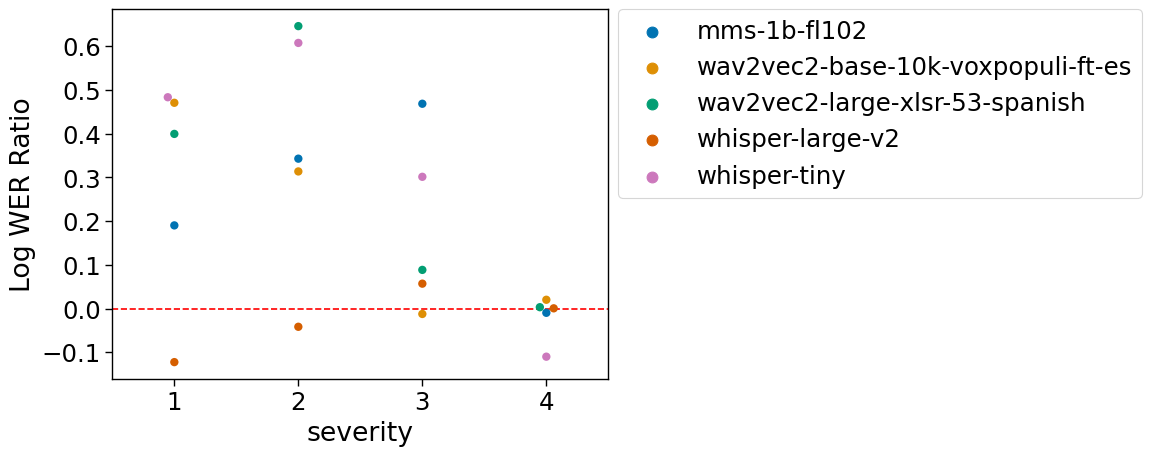

In [181]:
data=severity_results_diff_df[(severity_results_diff_df['dataset'] == 'multilingual_librispeech')]
data = data.pivot_table(index=['model', 'severity'], values=['Log WER Ratio', 'Log CER ratio']).reset_index()
print(data['model'].unique())
with sns.plotting_context('paper', font_scale=2.):
    # ax = corruption_results_dfg = sns.boxplot(data=data, x='severity', y='Log WER Ratio', showfliers=False)
    ax = corruption_results_dfg = sns.swarmplot(data=data, x='severity', y='Log WER Ratio', hue='model', size=6, palette='colorblind')
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    ax.axhline(0, ls='--', color='red')
# g.axes[0,0].bar_label(g.axes[0,0].containers[-1], fmt='%.2f', label_type='edge')

AttributeError: 'numpy.int64' object has no attribute 'startswith'

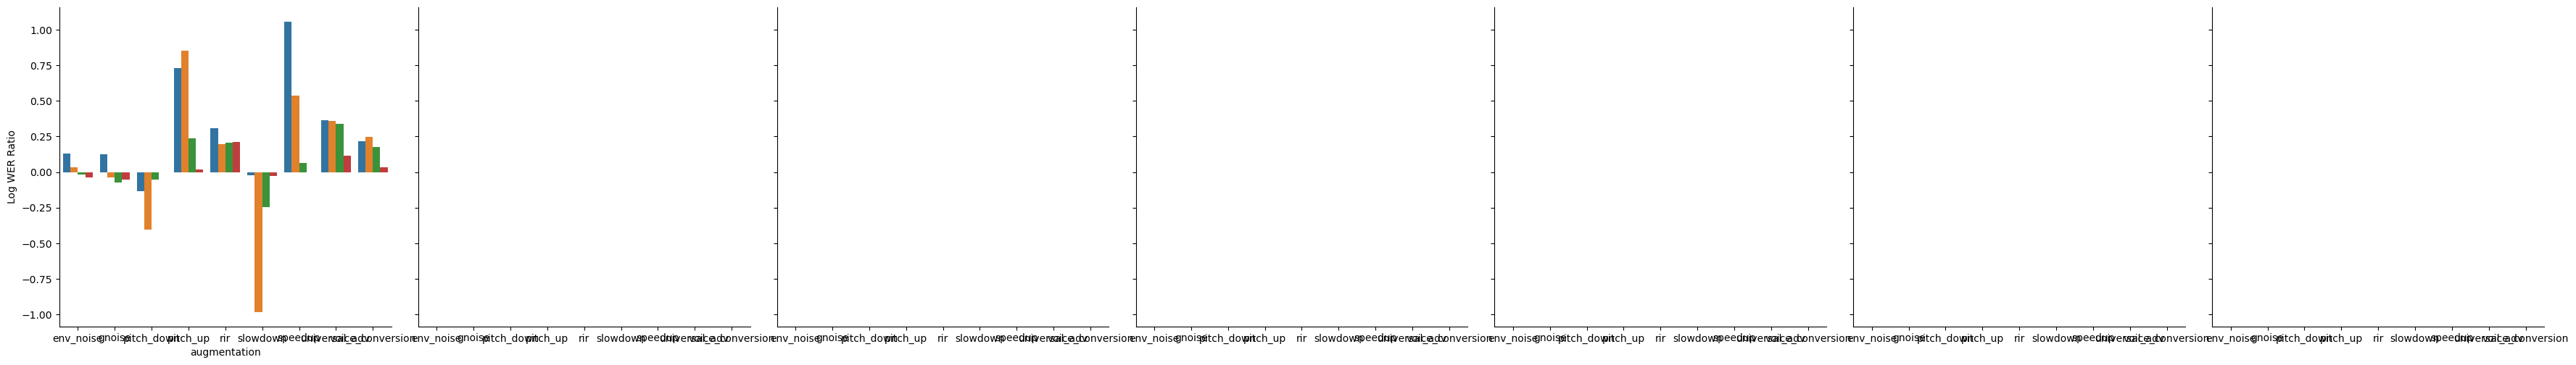

In [91]:
data = agg_results_diff_df[(agg_results_diff_df['dataset'] == 'librispeech_asr') & (agg_results_diff_df['model'].isin(en_models)) & (agg_results_diff_df['severity'] > 0) & ~(agg_results_diff_df['augmentation'].str.contains('\+'))]
g = sns.catplot(data=data, x='augmentation', y='Log WER Ratio', hue='severity', kind='bar', col='model')
g.set_xticklabels(rotation=-45, ha='left')

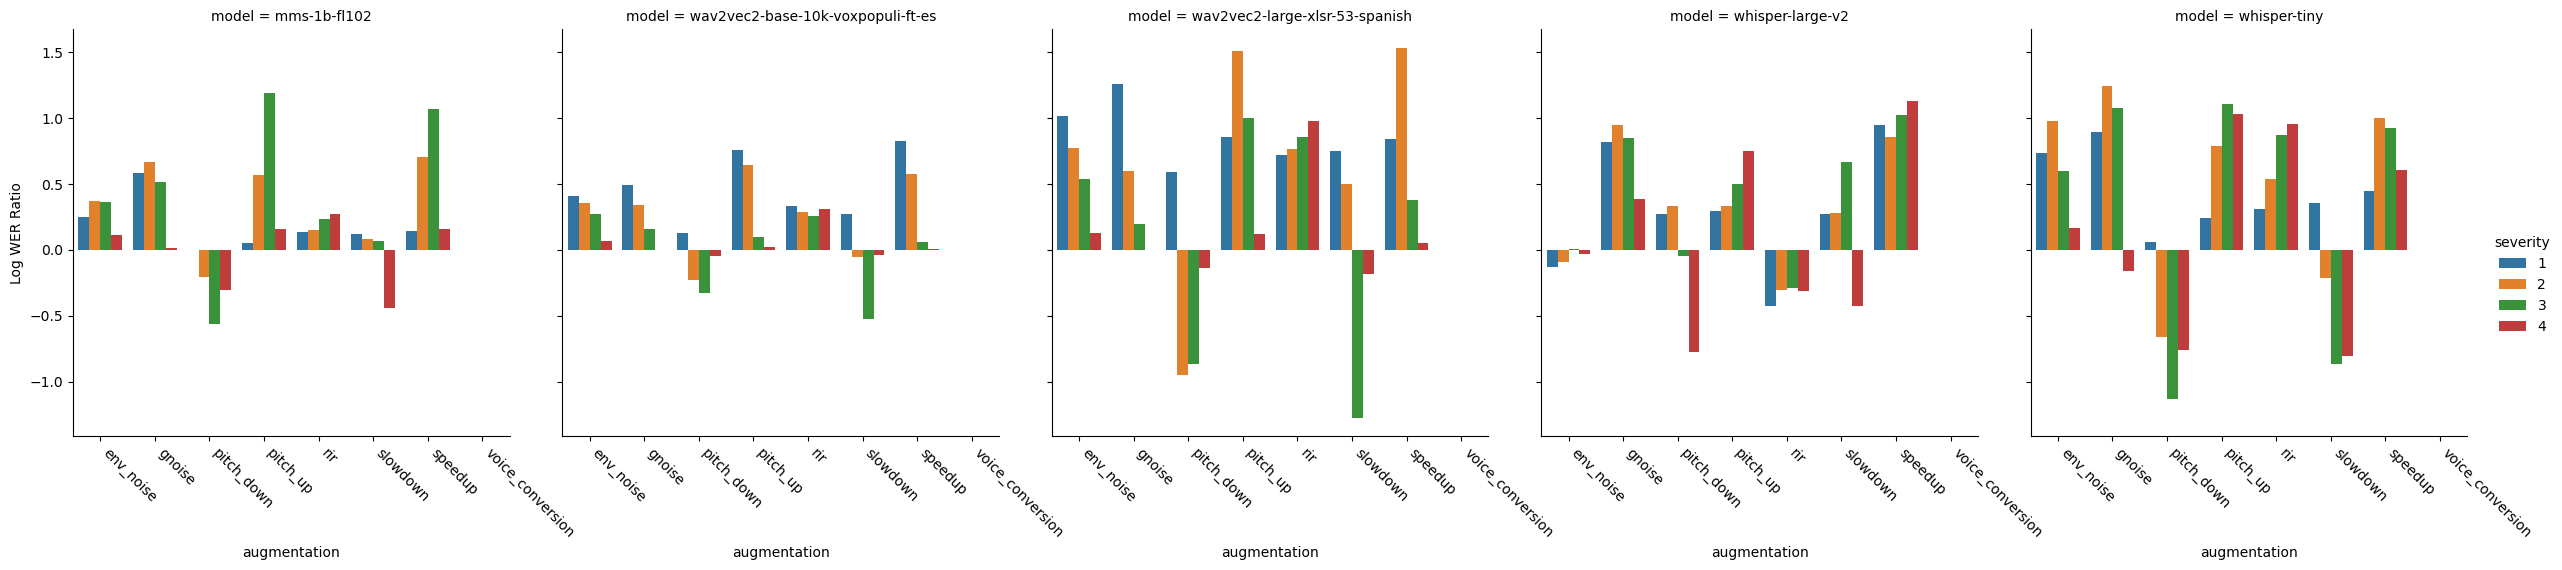

In [ ]:
data = agg_results_diff_df[(agg_results_diff_df['dataset'] == 'multilingual_librispeech') & (agg_results_diff_df['severity'] > 0) & ~(agg_results_diff_df['augmentation'].str.contains('\+'))]
g = sns.catplot(data=data, x='augmentation', y='Log WER Ratio', hue='severity', kind='bar', col='model')
g.set_xticklabels(rotation=-45, ha='left')

In [207]:
agg_results_diff_df[agg_results_diff_df['augmentation'] == 'env_noise'][['severity', 'Log WER Ratio']].corr()

,severity,Log WER Ratio
severity,1.000000,-0.333068
Log WER Ratio,-0.333068,1.000000


In [237]:
sns.ecdfplot(data=full_df[(full_df['model'] == 'whisper-tiny.en') & (full_df['augmentation'].isna())], x='cer', hue='speaker_gender', stat='proportion', complementary=True)

AttributeError: module 'seaborn' has no attribute 'ecdfplot'

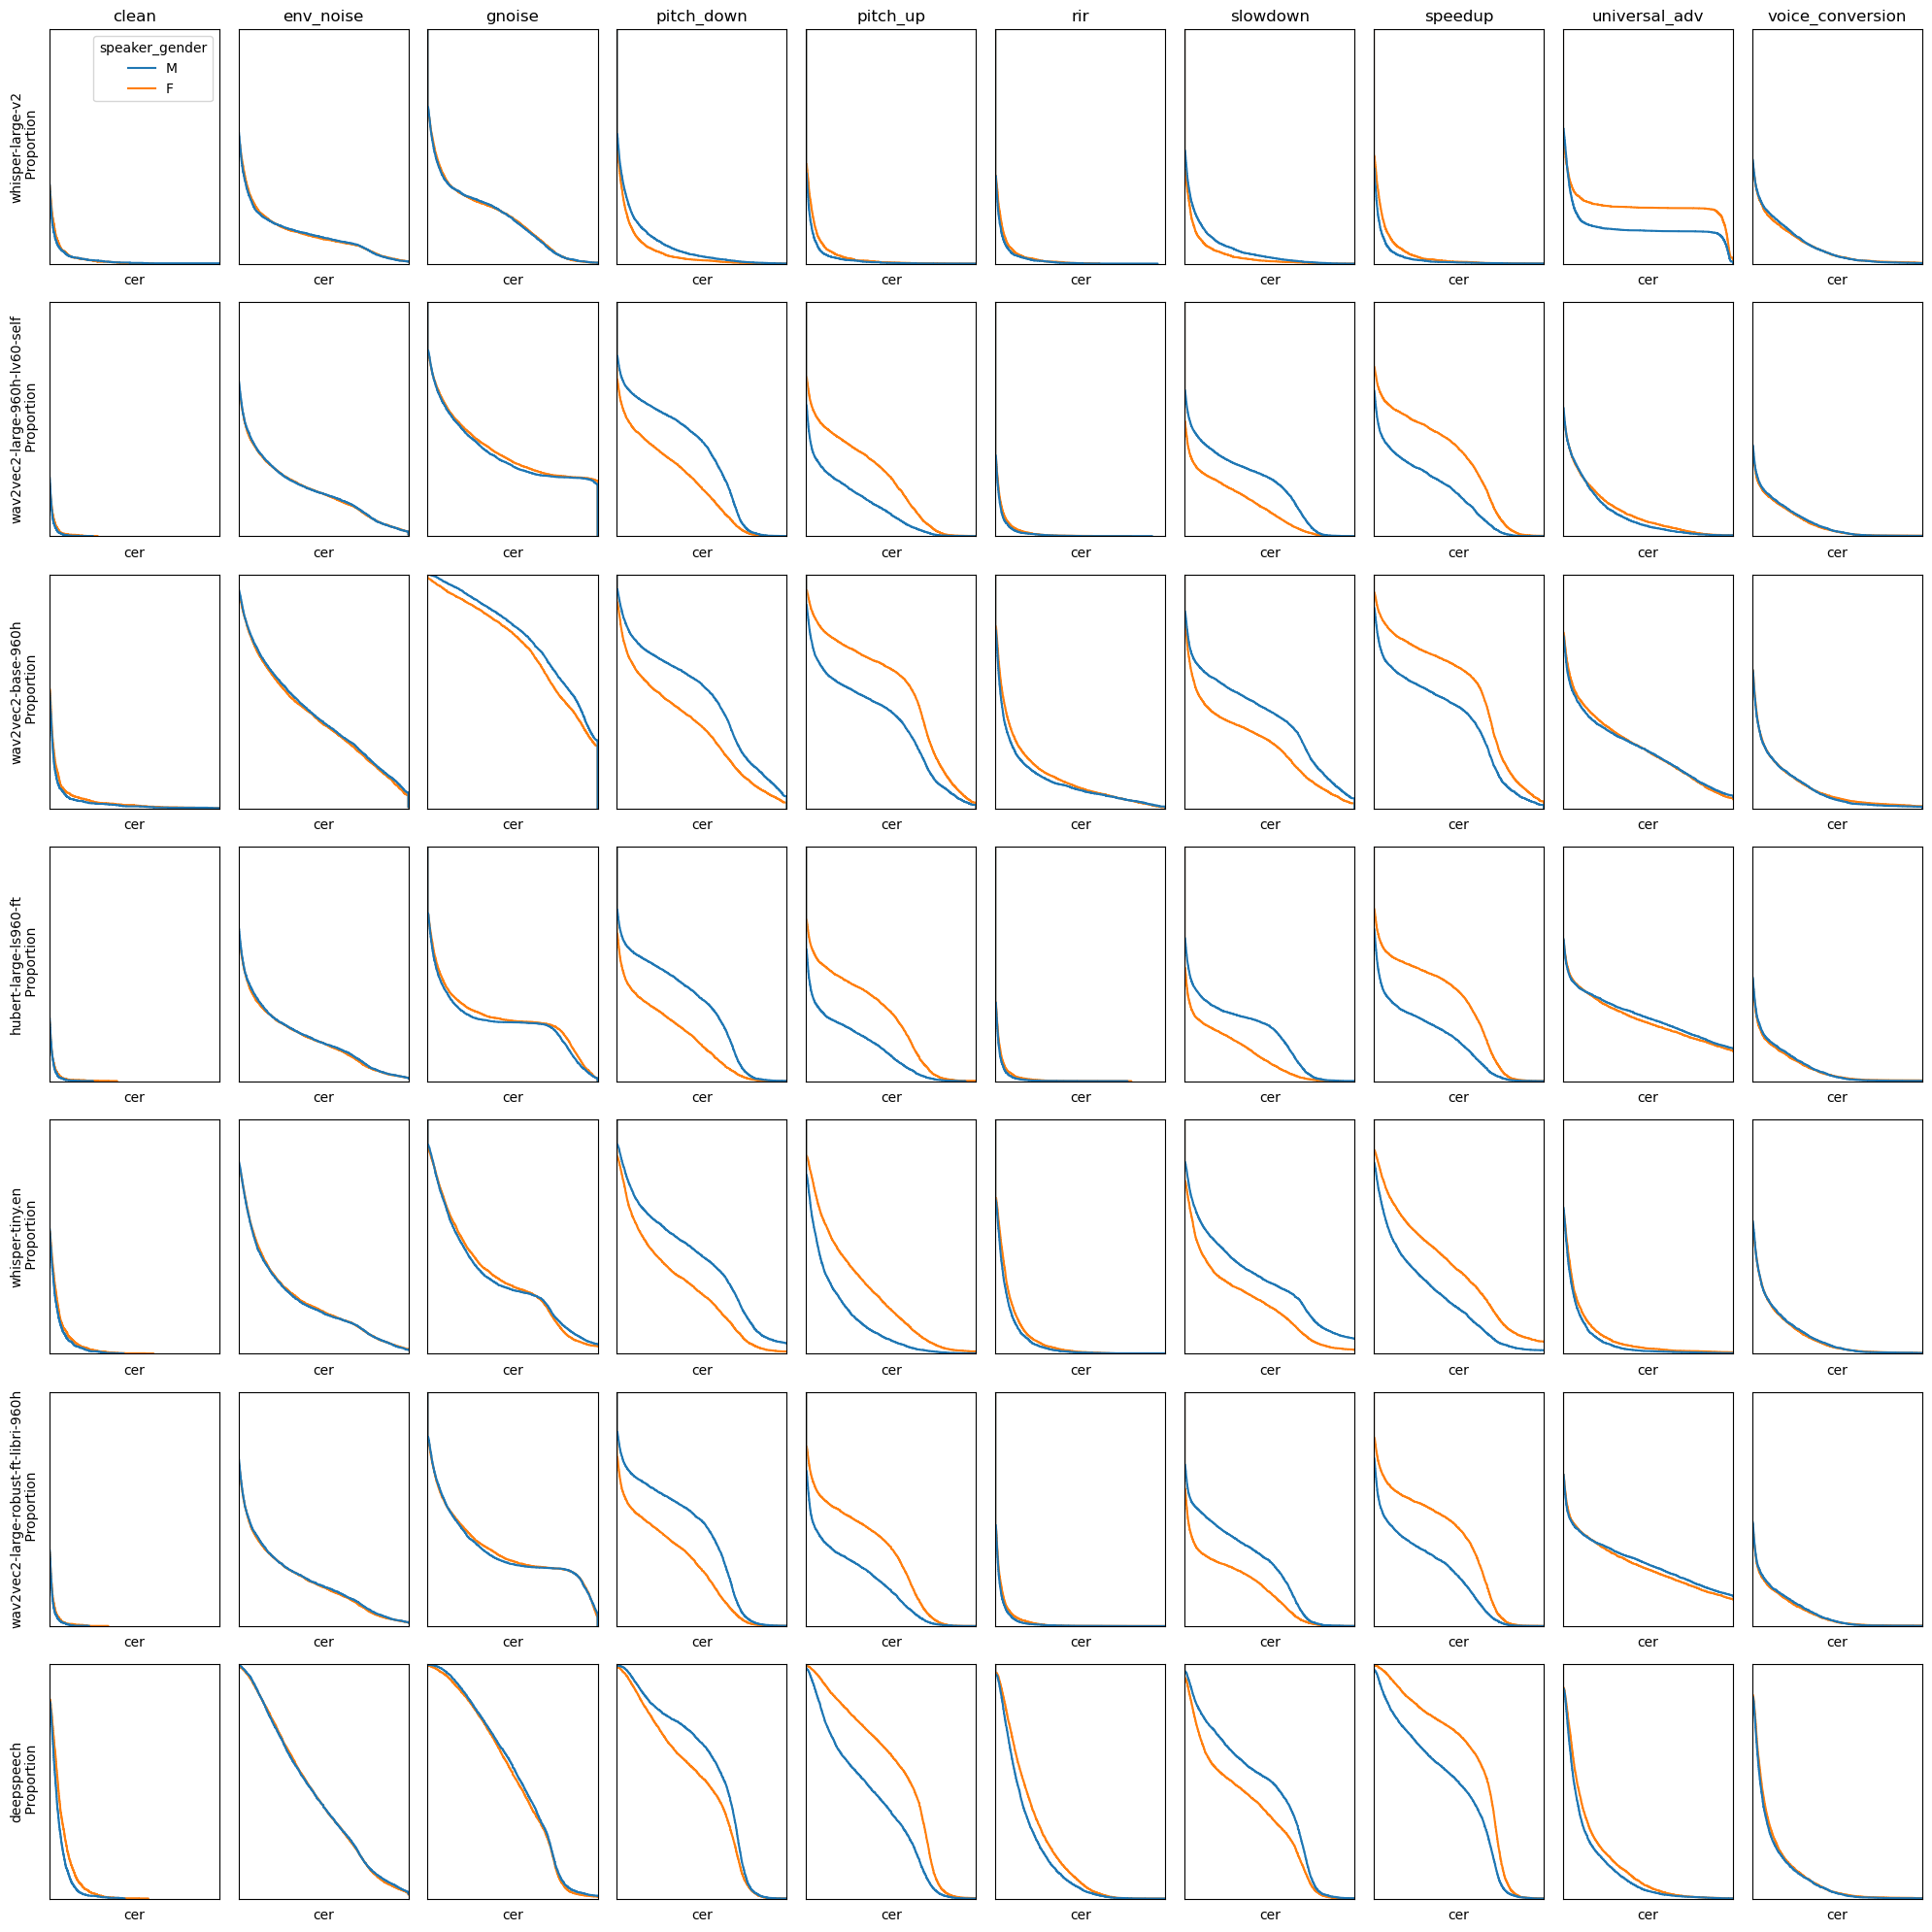

In [44]:
data = deepcopy(full_df)
data = data[data['dataset'] == 'librispeech_asr']
data['augmentation'].replace(np.nan, 'clean', inplace=True)
data = data[~(data['augmentation'].str.contains('+', regex=False))]
data = data[~(data['model'].isin(['emformer-rnnt', 'wav2vec2-large-960h', 'whisper-tiny']))]
_,axs = plt.subplots(len(data['model'].unique()), len(data['augmentation'].unique()), figsize=(20, 20))
for i, model in enumerate(data['model'].unique()):
    for j, aug in enumerate(sorted(data['augmentation'].unique())):
        ax = axs[i,j]
        sns.ecdfplot(data=data[(data['model'] == model) & (data['augmentation'] == aug)], x='cer', hue='speaker_gender', ax=ax, complementary=True, legend=(i==0 and j==0))
        ax.set_xlim(0, 1)
        if i == 0:
            ax.set_title(f'{aug}')
        if j == 0:
            ax.set_ylabel(f'{model}\n Proportion')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels('')
        ax.set_yticks([])
        ax.set_xticks([])
plt.tight_layout()

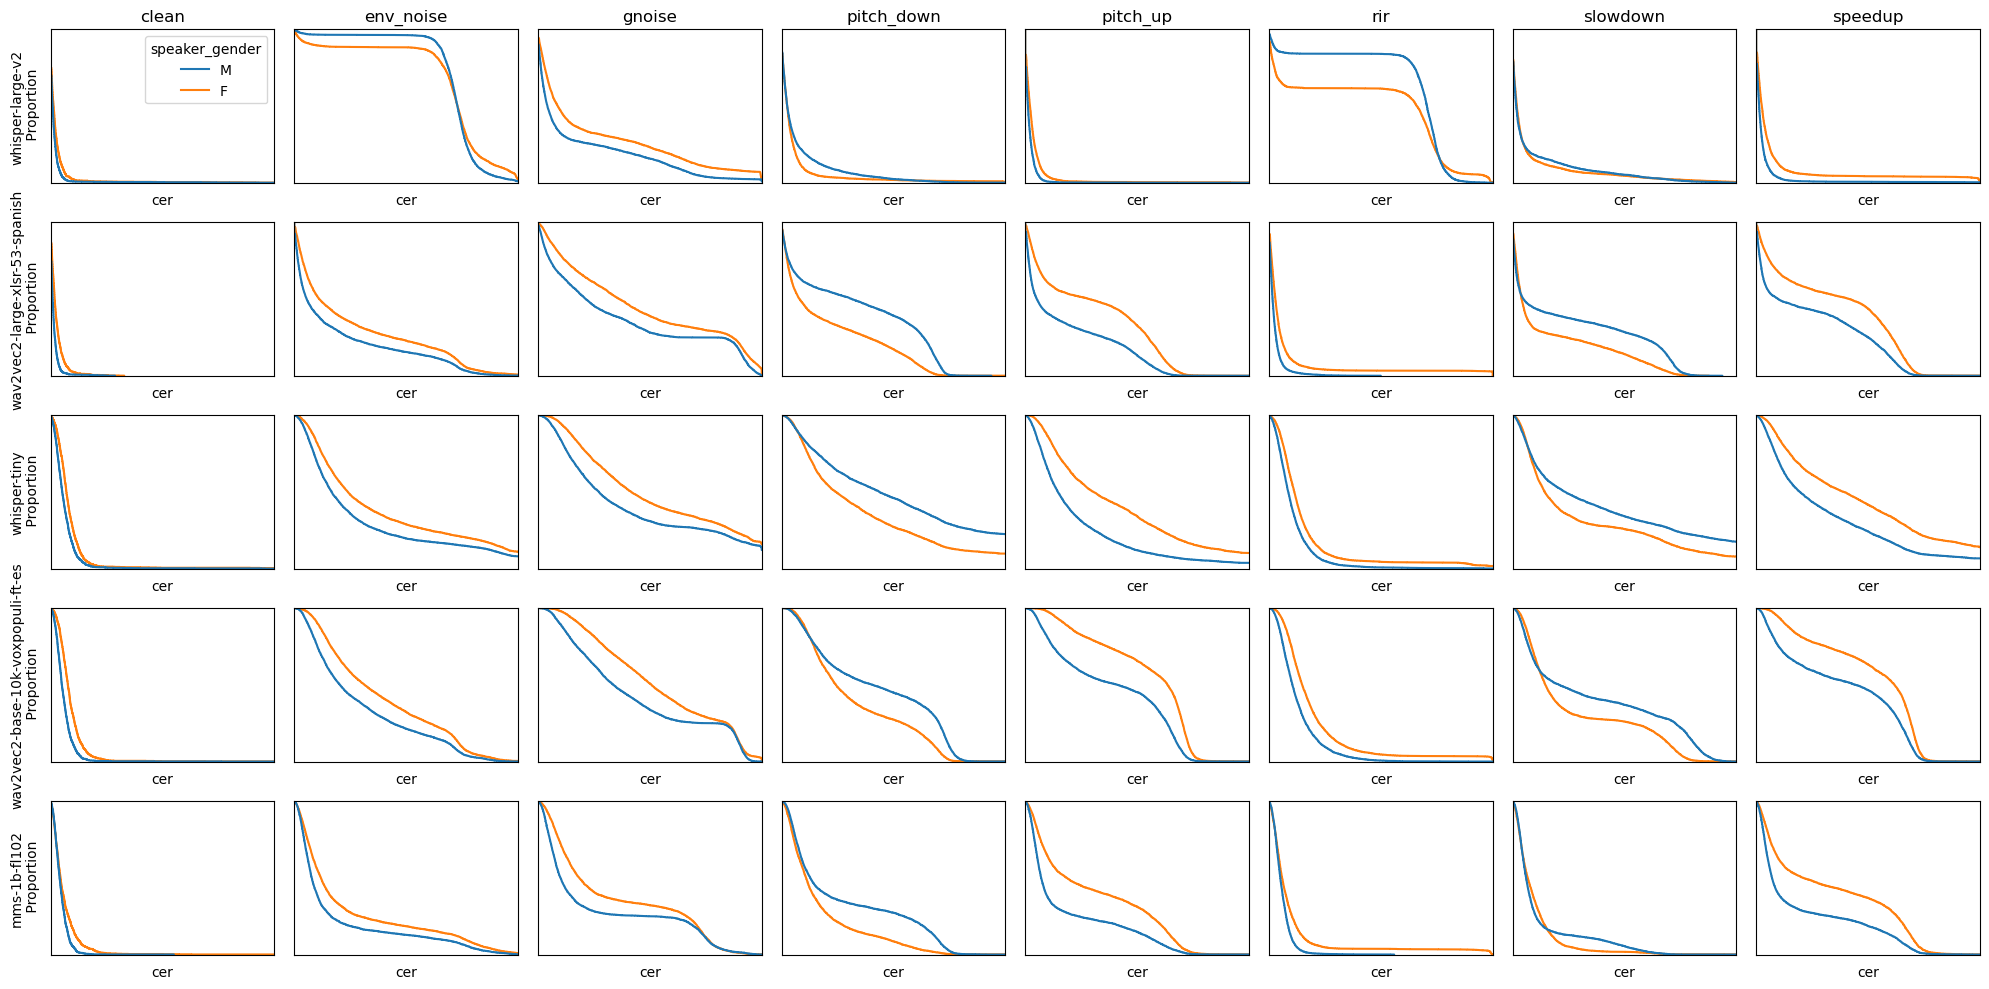

In [43]:
data = deepcopy(full_df)
data = data[data['dataset'] == 'multilingual_librispeech']
data['augmentation'].replace(np.nan, 'clean', inplace=True)
data = data[~(data['augmentation'].str.contains('+', regex=False))]
data = data[data['augmentation'] != 'voice_conversion']
_,axs = plt.subplots(len(data['model'].unique()), len(data['augmentation'].unique()), figsize=(20, 10))
for i, model in enumerate(data['model'].unique()):
    for j, aug in enumerate(sorted(data['augmentation'].unique())):
        ax = axs[i,j]
        sns.ecdfplot(data=data[(data['model'] == model) & (data['augmentation'] == aug)], x='cer', hue='speaker_gender', ax=ax, complementary=True, legend=(i==0 and j==0))
        ax.set_xlim(0, 1)
        if i == 0:
            ax.set_title(f'{aug}')
        if j == 0:
            ax.set_ylabel(f'{model}\n Proportion')
        else:
            ax.set_ylabel('')
            ax.set_yticklabels('')
        ax.set_yticks([])
        ax.set_xticks([])
plt.tight_layout()